# Packages 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## Inner CV

In [3]:
def inner_nested_cross_val(X, Y, cv, split_model, model, params):
    test_model = GridSearchCV(model, params, cv = cv ).fit(X, Y.values.ravel())
    return test_model.best_estimator_

## Roc_outer_cross_val

In [12]:
def roc_outer_cross_val(X, Y, model, params):
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 300)
    fold = 0
    groups = [1,2,3,4,5,6]
    # subject wise cross validation
    split_model = LeaveOneGroupOut()
    for train_index, test_index in split_model.split(X, Y, groups):
        
        X_train = X[train_index[0]]
        X_test = X[test_index[0]]
        Y_train = Y[train_index[0]]
        Y_test = Y[test_index[0]]
        
        for i in train_index[1:]:
            print( "index =",i)
            X_train = pd.concat([X_train,X[i]])
            Y_train = pd.concat([Y_train,Y[i]])

        print("--------------------")
        print('X_train:',str(X_train.shape),'Y_train:',str(Y_train.shape),'X_test:',str(X_test.shape),'Y_test:',str(Y_test.shape))
        
        
        cv = len(train_index)
        best_inner_model = inner_nested_cross_val(X_train, Y_train, cv, LeaveOneGroupOut(), model, params)

        best_inner_model.fit(X_train,Y_train.values.ravel())
        probas_ = best_inner_model.predict_proba(X_test)
        
        fpr, tpr, thresholds = roc_curve(Y_test.values.ravel(), probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        fold += 1
    
    return tprs,mean_fpr,aucs

# Load features with moving window

In [9]:
X = []
Y = []
print("reading features on moved window frame by:{} ms".format(10))
min_max_right_path = "../../../Features/min_max_right_feature/"
subjects = ['S1','S2','S3','C1','C2','C3']
lead_time = 200
for i in range(len(subjects)):
    feature = pd.read_csv(min_max_right_path+subjects[i]+"_"+str(lead_time)+ "ms.csv")
    X.append(feature[['min_acc','max_acc','right_most']])
    print(feature[['fall_value']].shape)
    Y.append(feature[['fall_value']])


reading features on moved window frame by:10 ms
(3138, 1)
(2840, 1)
(3027, 1)
(2710, 1)
(1777, 1)
(1815, 1)


In [13]:
X[0].head()

,min_acc,max_acc,right_most
0,862.481304,12665.353607,12665.353607
1,1108.108749,9574.734931,9574.734931
2,1365.536158,12653.205365,12653.205365
3,973.963552,13097.308006,13097.308006
4,349.598341,15686.813124,13457.327149


In [14]:
model = RandomForestClassifier(random_state=2)
n_estimators = list(range(50,120,10))
params = {'n_estimators':n_estimators}


## ROC graph on moving window

In [16]:
lead_times = [10,100,200,300,400,2000]
plt.figure(figsize=(10,7))
auc_values = []
dict_tpr = dict()
dict_fpr = dict()
dict_auc = dict()

for lead_time in lead_times:
    X = []
    Y = []
    print("predicting on features by moved window frame by:{} ms".format(lead_time))
    for i in range(len(subjects)):
        feature = pd.read_csv(min_max_right_path+subjects[i]+"_"+str(lead_time)+ "ms.csv")
        X.append(feature[['min_acc','max_acc','right_most']])
        Y.append(feature[['fall_value']])
    tprs,mean_fpr,aucs = roc_outer_cross_val(X, Y, model, params)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    auc_values.append(round(mean_auc,3))
    std_auc = np.std(aucs)
    dict_tpr[lead_time] = mean_tpr
    dict_fpr[lead_time] = mean_fpr
    dict_auc[lead_time] = aucs

predicting on features by moved window frame by:10 ms
--------------------
X_train: (12203, 3) Y_train: (12203, 1) X_test: (3142, 3) Y_test: (3142, 1)
--------------------
X_train: (12496, 3) Y_train: (12496, 1) X_test: (2849, 3) Y_test: (2849, 1)
--------------------
X_train: (12312, 3) Y_train: (12312, 1) X_test: (3033, 3) Y_test: (3033, 1)
--------------------
X_train: (12629, 3) Y_train: (12629, 1) X_test: (2716, 3) Y_test: (2716, 1)
--------------------
X_train: (13560, 3) Y_train: (13560, 1) X_test: (1785, 3) Y_test: (1785, 1)
--------------------
X_train: (13525, 3) Y_train: (13525, 1) X_test: (1820, 3) Y_test: (1820, 1)
predicting on features by moved window frame by:100 ms
--------------------
X_train: (12185, 3) Y_train: (12185, 1) X_test: (3140, 3) Y_test: (3140, 1)
--------------------
X_train: (12479, 3) Y_train: (12479, 1) X_test: (2846, 3) Y_test: (2846, 1)
--------------------
X_train: (12295, 3) Y_train: (12295, 1) X_test: (3030, 3) Y_test: (3030, 1)
------------------

<Figure size 720x504 with 0 Axes>

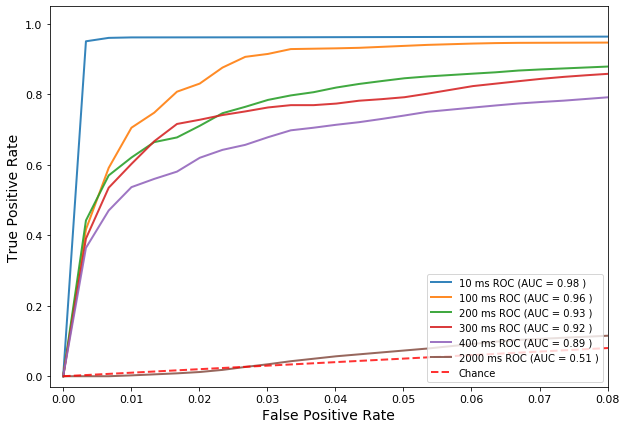

In [17]:
move_window = [10,100,200,300,400,2000]
plt.figure(figsize=(10,7))
auc_values = []
specificity = 0.99
tpr_tnr_table = pd.DataFrame(columns={'lead time(in ms)','sensitivity','specificity'})

for lead_time in lead_times:
    mean_tpr = dict_tpr[lead_time]
    mean_fpr = dict_fpr[lead_time]
    aucs = dict_auc[lead_time] 
    sensitivity = np.interp(1-specificity,mean_fpr,mean_tpr)
    tpr_tnr_table = tpr_tnr_table.append({'lead time(in ms)':lead_time,'sensitivity':round(sensitivity,3),
                                          'specificity':(specificity)},
                       ignore_index = True)
    mean_auc = auc(mean_fpr, mean_tpr)
    auc_values.append(round(mean_auc,3))
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr,
             label=str(lead_time)+' ms ROC (AUC = %0.2f )' % (mean_auc),
             lw=2, alpha=.9)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
     label='Chance', alpha=.8) 

plt.xlim([-0.002, 0.08])
plt.ylim([-0.03, 1.05])

plt.tick_params(labelsize=11)
plt.xlabel('False Positive Rate',fontsize = 14 )
plt.ylabel('True Positive Rate', fontsize = 14 )
plt.legend(loc="lower right")
img_name = 'ROC_curve'+' ms.png'
plt.savefig(img_name,bbox_inches='tight')
plt.show()

In [18]:
tpr_tnr_table['AUC'] = auc_values

In [19]:
tpr_tnr_table.head(7)

,specificity,lead time(in ms),sensitivity,AUC
0,0.99,10.0,0.962,0.979
1,0.99,100.0,0.704,0.964
2,0.99,200.0,0.620,0.927
3,0.99,300.0,0.602,0.923
4,0.99,400.0,0.536,0.894
5,0.99,2000.0,0.002,0.509


In [ ]:
# Modifying the data like converting float to int and adding percentage value to sensitivity
tpr_tnr_table['lead time(in ms)'] = tpr_tnr_table['lead time(in ms)'].astype('int64')
# Dropped the sensitivity column
tpr_tnr_table = tpr_tnr_table.drop('specificity',axis=1)
tpr_tnr_table['sensitivity'] = tpr_tnr_table['sensitivity'].apply(lambda x : str(round(x*100,1))+" %") 
tpr_tnr_table.head(7)

In [22]:
tpr_tnr_table.head(7)

,lead time(in ms),sensitivity,AUC
0,10,96.2 %,0.979
1,100,70.4 %,0.964
2,200,62.0 %,0.927
3,300,60.2 %,0.923
4,400,53.6 %,0.894
5,2000,0.2 %,0.509
